In [17]:
from qiskit import *
import numpy as np

In [18]:
def odd_block(circuit, params) :
    for qubit in range(len(params)) :
             circuit.rx(params[qubit], qubit)
        
    return circuit

In [19]:
def even_block(circuit, params) :
    l = len(params)
    
    for qubit in range(l) :
        circuit.rz(params[qubit], qubit)
        
    for i in range(l - 1):
        for j in range(i + 1, l):
            circuit.cz(i, j)
            
    return circuit

In [20]:
def circuit(params, n_qubits = 4) :
    qc = QuantumCircuit(n_qubits)
    
    for block in range(0, len(params), 2) :
        qc = even_block(odd_block(qc, params[block]), params[block + 1])
        qc.barrier()
        
    return qc

In [21]:
def initialize_params(L, n_qubits = 4) :
    return 2*np.pi*np.random.random_sample((2 * L, n_qubits))

In [22]:
def get_statevector(circuit) :
    backend = Aer.get_backend('statevector_simulator')
    return execute(circuit, backend).result().get_statevector()

In [23]:
def random_state(n_qubits = 4):
    return quantum_info.random_statevector(2 ** n_qubits, seed = None).data

In [24]:
def epsilon(psi, phi) :
    difference = psi - phi
    return sum(difference.real ** 2 + difference.imag ** 2)

In [25]:
def update_params(current_params, phi, learning_rate, delta) :
    derivatives = np.zeros(current_params.shape)
    for i in range(current_params.shape[0]) :
        for j in range(current_params.shape[1]) :
            current_params[i][j] += delta
            plus_delta = get_statevector(circuit(current_params))
            
            current_params[i][j] -= 2 * delta
            minus_delta = get_statevector(circuit(current_params))
            
            current_params[i][j] += delta
            derivatives[i][j] = (epsilon(plus_delta, phi) - epsilon(minus_delta, phi)) / (2 * delta)
    current_params -= learning_rate * derivatives
    
    return current_params

In [26]:
def gradient_descent(phi, L, learning_rate = 0.1, delta = 0.05, iterations = 500):
    current_params = initialize_params(L)
    X = []
    Y = []
    
    for i in range(iterations) :
        current_params = update_params(current_params, phi, learning_rate, delta)
        if i % (iterations // 10) == 0:
            X.append(i)
            state = get_statevector(circuit(current_params))
            Y.append(epsilon(state, phi))
            
    return current_params, epsilon(get_statevector(circuit(current_params)), phi), X, Y

In [27]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The minimum distance for 1 layers : 0.5879486203887534
The minimum distance for 2 layers : 0.5896624979861912
The minimum distance for 3 layers : 0.05533765026710083
The minimum distance for 4 layers : 0.026541312884487522
The minimum distance for 5 layers : 0.010643789658071875
The minimum distance for 6 layers : 0.006065583160273607
The minimum distance for 7 layers : 0.004099246963452502
The minimum distance for 8 layers : 8.451221122778736e-05
The minimum distance for 9 layers : 3.2429773790715785e-05
The minimum distance for 10 layers : 6.410872353589588e-06
The minimum distance for 11 layers : 2.1500494060391584e-06
The minimum distance for 12 layers : 1.1880783965309031e-07
The minimum distance for 13 layers : 4.500844650153858e-08
The minimum distance for 14 layers : 3.209043619099076e-08


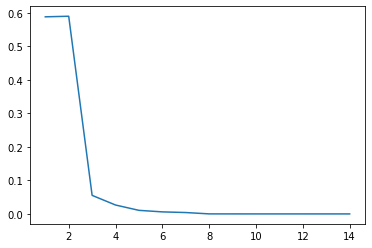

In [45]:
phi = (random_state(4))
layers, min_distances = range(1, 15), []
for L in range(1, 15) :
    alpha = 0.05 if L > 5 else (0.4 if L < 3 else 0.1) 
    params, eps, X, Y = gradient_descent(phi, L, learning_rate = alpha, delta = 0.05, iterations = 500)
    min_distances.append(eps)
    print(f"The minimum distance for {L} layers : {eps}")
plt.plot(layers, min_distances)
plt.show()

The parameters of the circuit for minimizing the distance are calculated by the method of Gradient Descent. It involves calculation of partial derivatives with respect to each parameter. Here these partial derivatives are calculated by approxmation. Therefore, the algorithm requires 3 hyperparameters - learning rate, number of iterations and delta.
The above plot is for number of layers in the range of 1 - 15 and the hyperparameters were chosen accordingly(learning_rate = 0.05, number of iterations = 500, delta = 0.05) for giving the best results.

For the plot we can infer that as number of layers increases (i.e. as number of parameters that needs to be tuned increases), the minimum distance decreases. This means the gradient descent is giving better results for higher number of parameters.